$$AeroData Competition: Flight Price Prediction$$


---



---


## Objective:
* Building a machine learning model to accurately predict flight ticket prices. This notebook covers the entire process from data exploration and cleaning to feature engineering, model building, and evaluation.
--

---
Developed by: ***SUBHASH KUMAR RANA*** (<a href="https://www.linkedin.com/in/indiansubhashkumar/">Linkedin</a>)(<a href="https://github.com/subhash2312res664/Indian-Flight-Price-Predictor">Github</a>)

DataSet: (<a href="https://docs.google.com/spreadsheets/d/1hiFFMy4TYevFPocdZONNAbalRS9YwZMg/edit?usp=sharing&ouid=107437412821556658749&rtpof=true&sd=true">Link</a>)

Date: 16th September, 2025.

---


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn import metrics
import pickle

In [47]:
# Set plot style
sns.set(style="whitegrid")
plt.style.use("ggplot")

# Load and Inspect the Dataset

In [48]:
data = pd.read_excel('IndianFlightdata.xlsx')
df = data.copy()


In [49]:
# First 5 rows
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
       Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR → DEL   
1    Air India       1/05/2019   Kolkata    Banglore  CCU → IXR → BBI → BLR   
2  Jet Airways       9/06/2019     Delhi      Cochin  DEL → LKO → BOM → COK   
3       IndiGo      12/05/2019   Kolkata    Banglore        CCU → NAG → BLR   
4       IndiGo      01/03/2019  Banglore   New Delhi        BLR → NAG → DEL   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897  
1    05:50         13:15   7h 25m     2 stops         No info   7662  
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882  
3    18:05         23:30   5h 25m      1 stop         No info   6218  
4    16:50         21:35   4h 45m      1 stop         No info  13302  


In [50]:
# Dataset info
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


# Data Cleaning and Preprocessing

In [51]:
# Check for and handle missing values
print("\nMissing values per column:")
print(df.isnull().sum())
df.dropna(inplace=True)
print("\nMissing values after cleaning:")
print(df.isnull().sum())


Missing values per column:
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

Missing values after cleaning:
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64


# --- Feature Extraction from Date/Time Columns ---

In [52]:
# Convert 'Date_of_Journey' to datetime
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')


In [53]:
# Extract day and month
df['Journey_Day'] = df['Date_of_Journey'].dt.day
df['Journey_Month'] = df['Date_of_Journey'].dt.month

In [54]:
# Extract hour and minute from 'Dep_Time' and 'Arrival_Time'
df['Dep_Hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
df['Dep_Min'] = pd.to_datetime(df['Dep_Time']).dt.minute
df['Arrival_Hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
df['Arrival_Min'] = pd.to_datetime(df['Arrival_Time']).dt.minute

/tmp/ipython-input-3977151279.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dep_Hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
/tmp/ipython-input-3977151279.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dep_Min'] = pd.to_datetime(df['Dep_Time']).dt.minute
/tmp/ipython-input-3977151279.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Arrival_Hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
/tmp/ipython-input-3977151279.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure p

In [55]:
# Drop original date/time columns
df.drop(['Date_of_Journey', 'Dep_Time', 'Arrival_Time'], axis=1, inplace=True)

In [56]:
# --- Standardizing 'Duration' and 'Total_Stops' ---

# Convert 'Duration' to total minutes
def convert_duration_to_minutes(duration):
    hours = 0
    minutes = 0
    if 'h' in duration:
        hours = int(duration.split('h')[0])
        if 'm' in duration.split('h')[1]:
            minutes = int(duration.split('h')[1].strip().split('m')[0])
    elif 'm' in duration:
        minutes = int(duration.split('m')[0])
    return hours * 60 + minutes

df['Duration_in_Mins'] = df['Duration'].apply(convert_duration_to_minutes)
df.drop('Duration', axis=1, inplace=True)

In [57]:
# Convert 'Total_Stops' to numerical values
stops_mapping = {'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4}
df['Total_Stops'] = df['Total_Stops'].map(stops_mapping)

print("\nDataset after preprocessing:")
print(df.head())


Dataset after preprocessing:
       Airline    Source Destination                  Route  Total_Stops  \
0       IndiGo  Banglore   New Delhi              BLR → DEL            0   
1    Air India   Kolkata    Banglore  CCU → IXR → BBI → BLR            2   
2  Jet Airways     Delhi      Cochin  DEL → LKO → BOM → COK            2   
3       IndiGo   Kolkata    Banglore        CCU → NAG → BLR            1   
4       IndiGo  Banglore   New Delhi        BLR → NAG → DEL            1   

  Additional_Info  Price  Journey_Day  Journey_Month  Dep_Hour  Dep_Min  \
0         No info   3897           24              3        22       20   
1         No info   7662            1              5         5       50   
2         No info  13882            9              6         9       25   
3         No info   6218           12              5        18        5   
4         No info  13302            1              3        16       50   

   Arrival_Hour  Arrival_Min  Duration_in_Mins  
0            

# Exploratory Data Analysis (EDA)

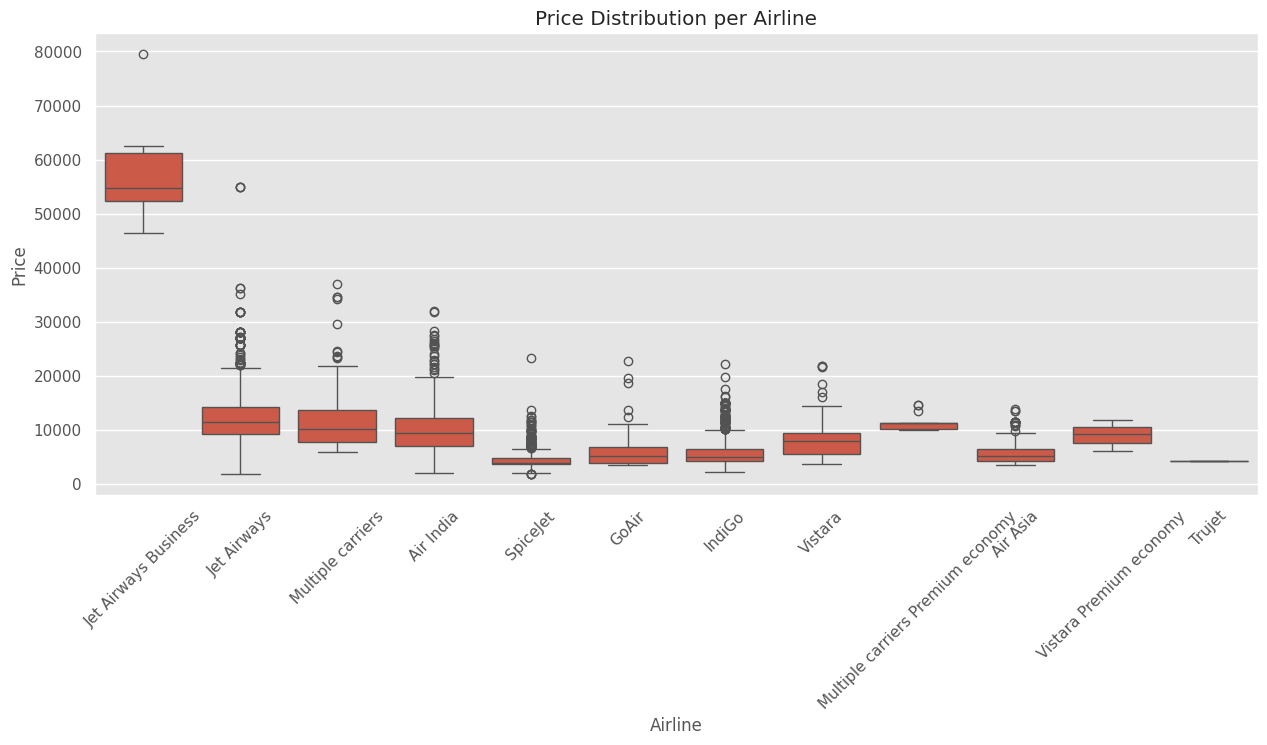

In [58]:
# Price vs. Airline
plt.figure(figsize=(15, 6))
sns.boxplot(x='Airline', y='Price', data=df.sort_values('Price', ascending=False))
plt.title('Price Distribution per Airline')
plt.xticks(rotation=45)
plt.show()

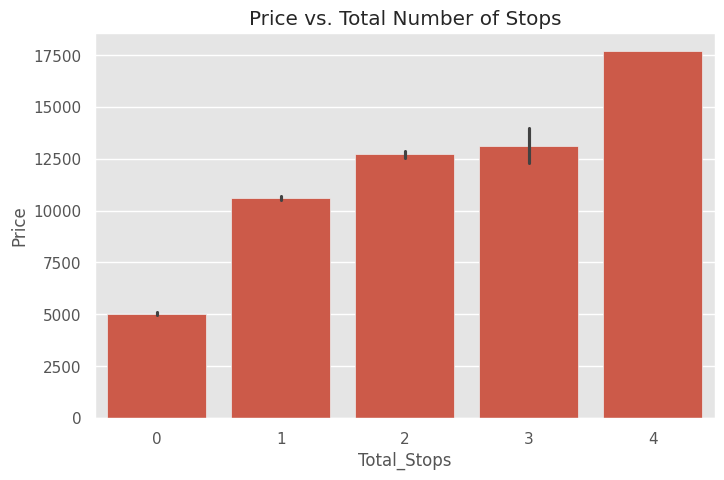

In [59]:
# Price vs. Total Stops
plt.figure(figsize=(8, 5))
sns.barplot(x='Total_Stops', y='Price', data=df)
plt.title('Price vs. Total Number of Stops')
plt.show()

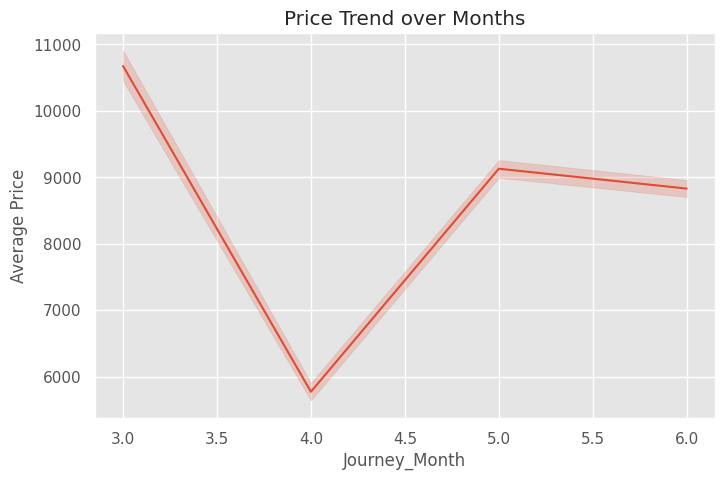

In [60]:
# Price vs. Journey Month
plt.figure(figsize=(8, 5))
sns.lineplot(x='Journey_Month', y='Price', data=df)
plt.title('Price Trend over Months')
plt.ylabel('Average Price')
plt.show()

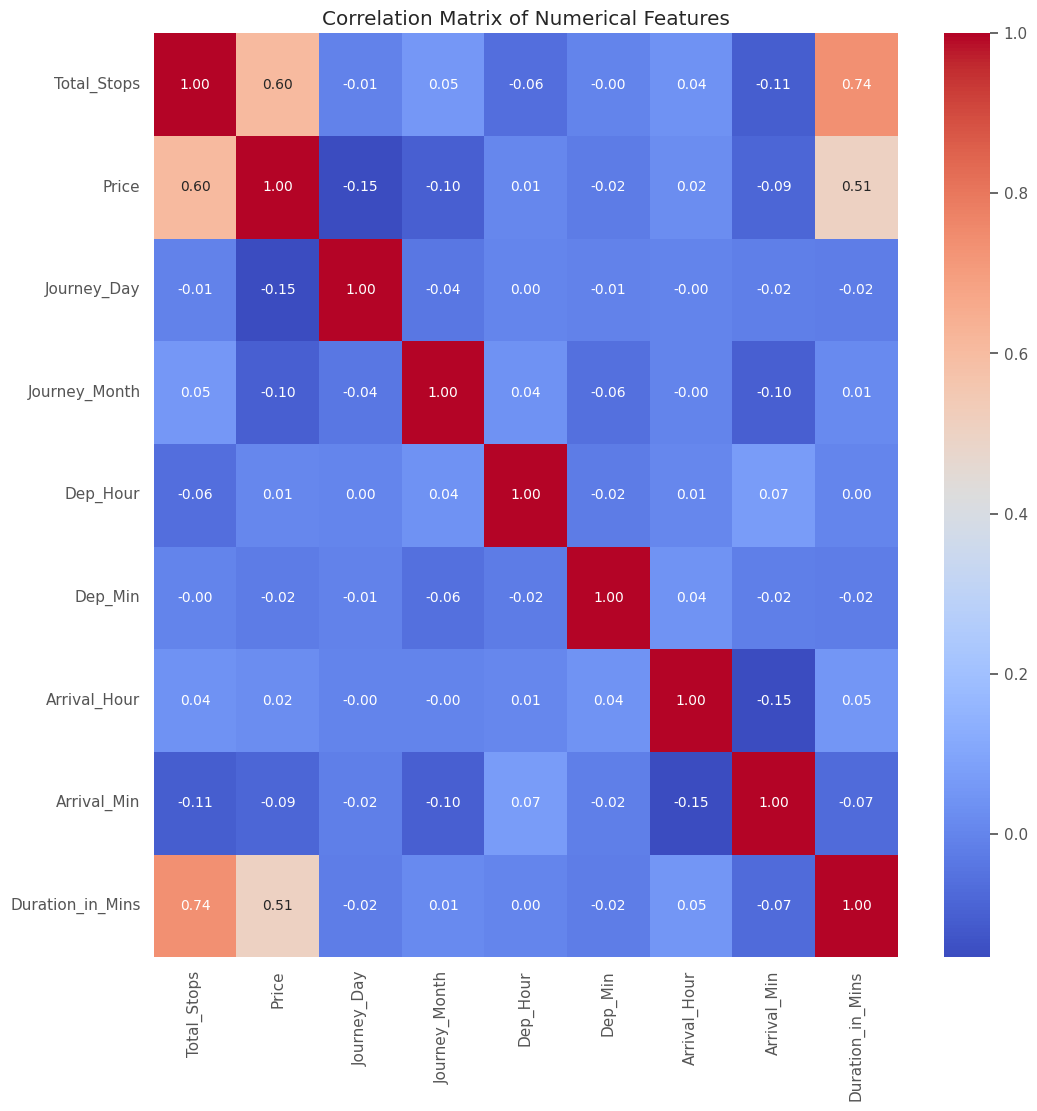

In [61]:
# Correlation Heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


# Handling Categorical Features

In [62]:
# Drop 'Route' and 'Additional_Info'
df.drop(['Route', 'Additional_Info'], axis=1, inplace=True)

In [63]:
# One-Hot Encoding for 'Airline', 'Source', 'Destination'
categorical_cols = ['Airline', 'Source', 'Destination']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cols = pd.DataFrame(encoder.fit_transform(df[categorical_cols]))
encoded_cols.columns = encoder.get_feature_names_out(categorical_cols)

In [64]:
# Reset index for concatenation
df.reset_index(drop=True, inplace=True)
encoded_cols.reset_index(drop=True, inplace=True)

In [65]:
# Combine original data with encoded columns
df_final = pd.concat([df.drop(categorical_cols, axis=1), encoded_cols], axis=1)

print("\nFinal dataset shape:", df_final.shape)
print("Final columns:", df_final.columns)



Final dataset shape: (10682, 32)
Final columns: Index(['Total_Stops', 'Price', 'Journey_Day', 'Journey_Month', 'Dep_Hour',
       'Dep_Min', 'Arrival_Hour', 'Arrival_Min', 'Duration_in_Mins',
       'Airline_Air Asia', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Banglore', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata',
       'Source_Mumbai', 'Destination_Banglore', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata',
       'Destination_New Delhi'],
      dtype='object')


# Model Building and Training

In [66]:
# Define features (X) and target (y)
X = df_final.drop('Price', axis=1)
y = df_final['Price']

In [71]:
print("\nIdentifying important features using ExtraTreesRegressor...")
selection_model = ExtraTreesRegressor()
selection_model.fit(X, y)


Identifying important features using ExtraTreesRegressor...


ExtraTreesRegressor()

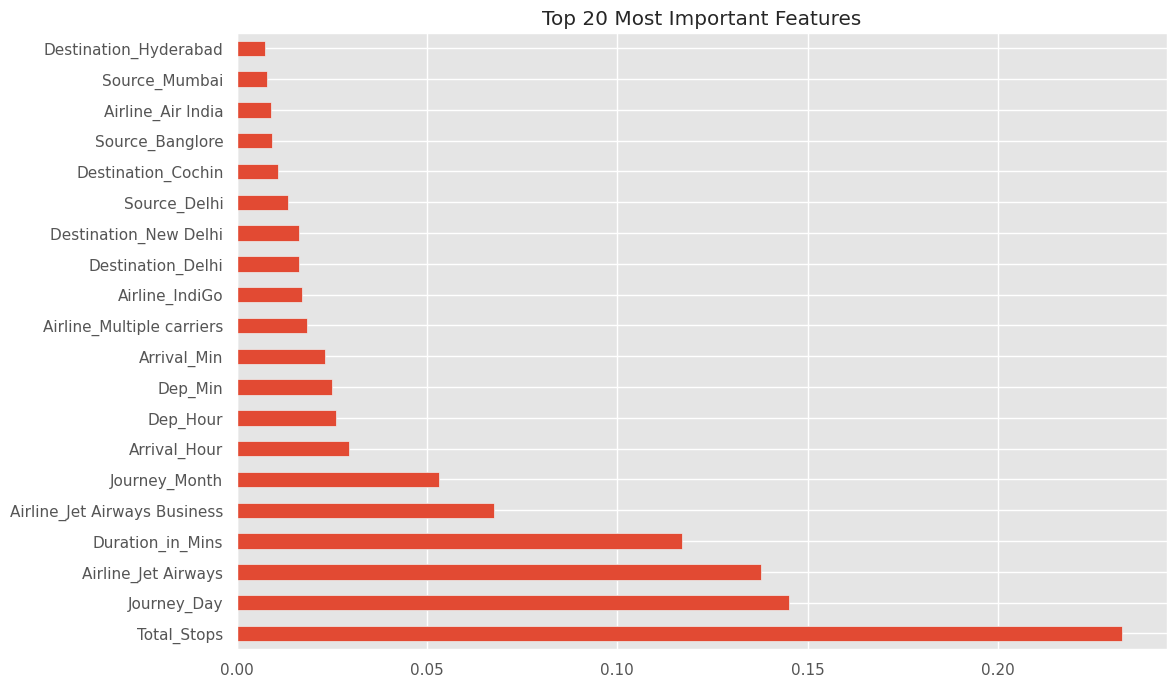

In [72]:
# Plotting feature importances
plt.figure(figsize=(12, 8))
feat_importances = pd.Series(selection_model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Top 20 Most Important Features")
plt.show()

In [73]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [74]:
# Initialize and train the RandomForestRegressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("\nTraining the RandomForest Regressor...")
rf_regressor.fit(X_train, y_train)
print("Training complete.")


Training the RandomForest Regressor...
Training complete.


# Model Evaluation

In [75]:
# Predictions
y_pred = rf_regressor.predict(X_test)

In [76]:
# Performance Metrics
print("\n--- Initial Model Performance ---")
print('R^2 Score:', metrics.r2_score(y_test, y_pred))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


--- Initial Model Performance ---
R^2 Score: 0.820973057781123
Mean Absolute Error (MAE): 1161.7093712202502
Root Mean Squared Error (RMSE): 1964.7363720524656


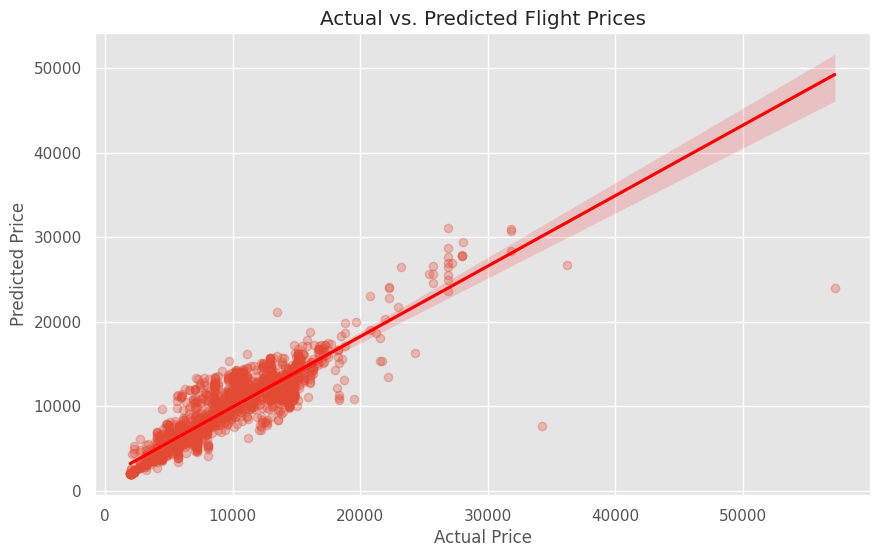

In [77]:
# Plot actual vs. predicted prices
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Flight Prices")
plt.show()

# Hyperparameter Tuning

In [79]:
# Using RandomizedSearchCV to find the best hyperparameters.

print("\nStarting Hyperparameter Tuning...")

# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


Starting Hyperparameter Tuning...


In [80]:
# Randomized Search setup
rf_random_search = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_grid,
                                      n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)


In [81]:
# Fit the search
rf_random_search.fit(X_train, y_train)

print("\nBest Hyperparameters Found:")
print(rf_random_search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best Hyperparameters Found:
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}


# Evaluate the Tuned Model

In [82]:
best_rf = rf_random_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)

print("\n--- Tuned Model Performance ---")
print('R^2 Score:', metrics.r2_score(y_test, y_pred_tuned))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred_tuned))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred_tuned)))


--- Tuned Model Performance ---
R^2 Score: 0.8314162820949638
Mean Absolute Error (MAE): 1227.8164615336657
Root Mean Squared Error (RMSE): 1906.5706440635747


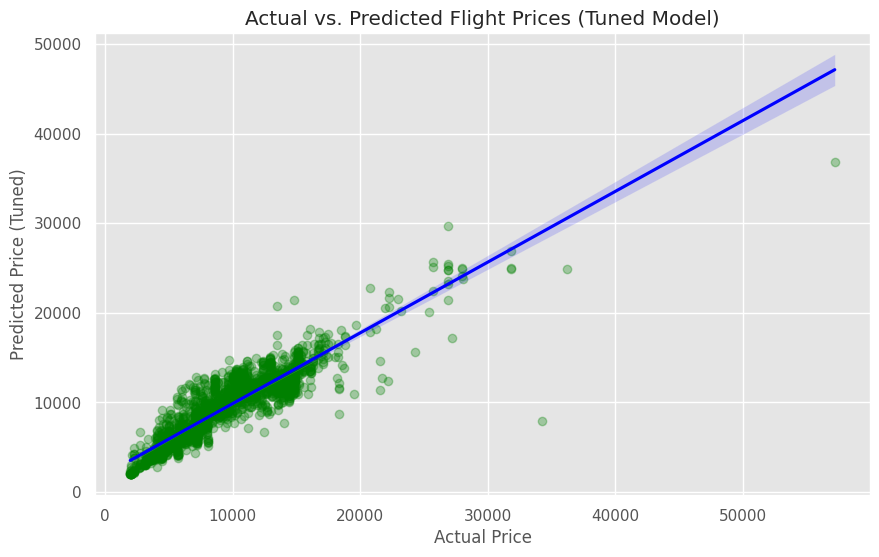

In [83]:
# Final visualization for the tuned model
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred_tuned, scatter_kws={'alpha':0.3, 'color':'green'}, line_kws={'color':'blue'})
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price (Tuned)")
plt.title("Actual vs. Predicted Flight Prices (Tuned Model)")
plt.show()

# Saving the Final Model

In [86]:
print("\nSaving the final model to 'flight_price_model.pkl'")
with open('flight_price_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)
print("Model saved successfully.")


Saving the final model to 'flight_price_model.pkl'
Model saved successfully.
